In [1]:
import gymnasium as gym
from gymnasium.wrappers.vector import NumpyToTorch
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/zhutchens/projects/RL/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
env = gym.make_vec(
    'CartPole-v1', 
    num_envs = 4, 
)
env = NumpyToTorch(env, device = device)

Checking out environments

In [3]:
env.observation_space

Box([[-4.8               -inf -0.41887903        -inf]
 [-4.8               -inf -0.41887903        -inf]
 [-4.8               -inf -0.41887903        -inf]
 [-4.8               -inf -0.41887903        -inf]], [[4.8               inf 0.41887903        inf]
 [4.8               inf 0.41887903        inf]
 [4.8               inf 0.41887903        inf]
 [4.8               inf 0.41887903        inf]], (4, 4), float32)

In [4]:
obs_sample = env.observation_space.sample()
obs_sample

array([[-4.4733505 , -1.2542576 , -0.1898189 ,  0.49557266],
       [ 1.5961576 ,  0.62764764,  0.26419038,  1.7766181 ],
       [-1.4998348 ,  1.392912  , -0.23623912, -0.136829  ],
       [-2.1369746 , -0.7790915 ,  0.07926133, -1.4679248 ]],
      dtype=float32)

In [5]:
obs_sample.shape

(4, 4)

In [6]:
env.action_space

MultiDiscrete([2 2 2 2])

In [7]:
actions_sample = env.action_space.sample()
actions_sample

array([1, 0, 1, 1])

In [8]:
states, info = env.reset()
states

tensor([[ 0.0483, -0.0035, -0.0103, -0.0365],
        [ 0.0473, -0.0354,  0.0068,  0.0218],
        [-0.0382, -0.0292,  0.0054,  0.0009],
        [ 0.0395,  0.0053, -0.0017, -0.0498]])

In [9]:
next_states, rewards, dones, terminated, _ = env.step(actions_sample)

In [10]:
next_states

tensor([[ 0.0482,  0.1917, -0.0111, -0.3324],
        [ 0.0466, -0.2306,  0.0072,  0.3166],
        [-0.0388,  0.1658,  0.0054, -0.2901],
        [ 0.0396,  0.2004, -0.0027, -0.3430]])

In [11]:
rewards

tensor([1., 1., 1., 1.])

In [12]:
dones # done is when state successfully finished or passed

tensor([False, False, False, False])

In [13]:
# test_dones = torch.from_numpy(dones)
# for i in range(test_dones.size().numel()):
#     print(test_dones[i])

In [14]:
terminated # terminated is when agent failed 

tensor([False, False, False, False])

Setting up networks

In [15]:
import random
import numpy as np
from src.ppo import *

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [16]:
actor = Actor(4, 2, 256).to(device)
critic = Critic(4, 1, 256).to(device)

In [17]:
obs_sample = torch.from_numpy(obs_sample).to(device)
dist = actor.forward(obs_sample)
dist

Categorical(logits: torch.Size([4, 2]))

In [18]:
test_sample = dist.sample()

In [19]:
dist.log_prob(test_sample)

tensor([-0.5726, -0.7315, -0.5330, -0.5507], grad_fn=<SqueezeBackward1>)

In [20]:
dist.log_prob(test_sample).exp()

tensor([0.5641, 0.4812, 0.5868, 0.5766], grad_fn=<ExpBackward0>)

In [21]:
critic.forward(obs_sample)

tensor([[-0.0930],
        [ 0.1536],
        [ 0.0372],
        [-0.0265]], grad_fn=<AddmmBackward0>)

In [22]:
# agent = Agent(actor, critic, 0.2, 0.99, 0.8, 0.5, 0.01, 0.0003, 0.0003, device, 8)
agent = Agent(actor, critic, 0.2, 0.99, 0.95, 0.5, 0.01, 0.0003, 0.001, device, 64)

In [23]:
train(env, agent, 80, 512, 4, 'models/cartpole_agent.pt', True)

finished episode: 0
total reward: 1969.0
number of steps: 512
---------------
new best model... saving...
finished episode: 1
total reward: 1982.0
number of steps: 512
---------------
new best model... saving...
finished episode: 2
total reward: 1997.0
number of steps: 512
---------------
new best model... saving...
finished episode: 3
total reward: 2005.0
number of steps: 512
---------------
new best model... saving...
finished episode: 4
total reward: 2010.0
number of steps: 512
---------------
new best model... saving...
finished episode: 5
total reward: 2022.0
number of steps: 512
---------------
new best model... saving...
finished episode: 6
total reward: 2026.0
number of steps: 512
---------------
new best model... saving...
finished episode: 7
total reward: 2024.0
number of steps: 512
---------------
finished episode: 8
total reward: 2033.0
number of steps: 512
---------------
new best model... saving...
finished episode: 9
total reward: 2027.0
number of steps: 512
------------

Text(0, 0.5, 'reward')

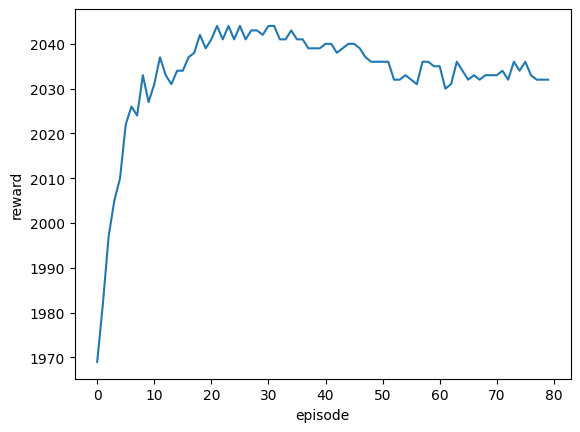

In [24]:
import matplotlib.pyplot as plt
plt.plot(agent.all_rewards)
plt.xlabel('episode')
plt.ylabel('reward')    

In [25]:
env.close()